In [ ]:
_ = """
Copyright 2021 The "Observing long-lived longwave contrail forcing" Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Any, Optional
import dask
import copy
import collections
import dateutil
import gcsfs
import statsmodels.formula.api as smf
from sklearn import linear_model
from tqdm import tqdm

In [ ]:
# The data are public, but you must login first.
from google.colab import auth
auth.authenticate_user()

In [ ]:
demo_pq_path = 'gs://contrails_external/longwave_dataset/v1/synthetic_tests/linear_a/dataset.pq_00000-of-03000'

In [ ]:
fs = gcsfs.GCSFileSystem()

def read_one_pq(path):
  with fs.open(path, 'rb') as f:
    return pd.read_parquet(f)

df = read_one_pq(demo_pq_path)
display(df.head())

,COIN_OLR,COIN_RSR,TOTAL_FLIGHT_DENSITY_BY_AGE_00,TOTAL_FLIGHT_DENSITY_BY_AGE_01,TOTAL_FLIGHT_DENSITY_BY_AGE_02,TOTAL_FLIGHT_DENSITY_BY_AGE_03,TOTAL_FLIGHT_DENSITY_BY_AGE_04,TOTAL_FLIGHT_DENSITY_BY_AGE_05,TOTAL_FLIGHT_DENSITY_BY_AGE_06,TOTAL_FLIGHT_DENSITY_BY_AGE_07,...,CLOUD_PHASE,SOLAR_INSOLATION,SOLAR_ZENITH_ANGLE,LAND_SURFACE_ALBEDO,GROUND_TRUTH_RF_SW,GROUND_TRUTH_RF_LW,t_eval,lat,lng,pixel_area_m2
0,280.990265,0.0,0.000000,0.005336,0.020369,0.001731,0.000719,0.000034,0.000000,0.000000,...,0.0,0.0,127.326447,0.015444,0.0,0.0,1584070800,-24.100020,-99.010536,5524323.3
0,286.683929,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000082,0.000591,...,0.0,0.0,135.303922,0.016976,0.0,0.0,1584070800,-24.510333,-88.808294,5004717.5
0,195.160309,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.0,0.0,116.484352,0.024500,0.0,0.0,1584070800,-59.977727,-63.315668,13340022.6
0,260.806641,0.0,0.278334,0.368780,0.142567,0.121265,0.124714,0.204768,0.299529,0.270418,...,1.0,0.0,130.495525,0.011319,0.0,0.0,1584070800,-40.220231,-78.940713,6425855.2
0,256.876099,0.0,0.017999,0.173978,0.216805,0.306272,0.368086,0.480682,0.448347,0.393406,...,0.0,0.0,131.263452,0.135000,0.0,0.0,1584070800,-44.105535,-66.582243,7214757.1


In [ ]:
def init_plt(params: Optional[dict[str, Any]] = None):
  """Initializes matplot defaults for all figures."""
  if params is None:
    params = {}
  default_params = {
      'legend.fontsize': 24,
      'figure.figsize': (15, 15),
      'axes.labelsize': 30,
      'axes.titlesize': 30,
      'xtick.labelsize': 30,
      'ytick.labelsize': 30,
  }
  default_params.update(params)
  plt.rcParams.update(default_params)
init_plt()

In [ ]:
def get_pq_glob(level: str) -> str:
  """Get parquet glob, given synthetic test type."""
  return f'gs://contrails_external/longwave_dataset/v1/synthetic_tests/{level}/dataset.pq_*-of-03000'

In [ ]:
def load_df(level, shards_num=84):
  pattern = get_pq_glob(level)
  tasks = []
  for p in fs.glob(pattern)[:shards_num]:
    tasks.append(dask.delayed(read_one_pq)(p))
  dfs = dask.compute(tasks)[0]
  return pd.concat(dfs)

In [ ]:
fd_cols = [f'flight_density_by_age_{age:02d}' for age in range(12)]

def add_fd_mean_lt_age(df, age):
  if not isinstance(age, int):
    raise ValueError()
  if age < 0 or age > 12:
    raise ValueError()

  df[f'fd_mean_lt_{age:02d}'] = np.mean(df[fd_cols[:age]].values, axis=-1)


def add_all_fd_mean_lt_ages(df):
  for i in range(1, 13):
    add_fd_mean_lt_age(df, i)

def preprocess_cloud_phase(df):
  """Corrects cloud phase to account for synthetic contrails."""
  if 'ground_truth_rf_lw' in df.columns:
    synth_contrail_pixel = (
        df[['ground_truth_rf_lw', 'ground_truth_rf_sw']] != 0
    ).any(axis=1)
    df['synth_cloud_phase'] = np.where(synth_contrail_pixel, 4, df.cloud_phase)
  # Drop rows with unknown cloud phase (primarily at edge of the viewing disc).
  # We need to copy it to avoid errors about mutating df views, but
  # we can delete the original immediately after to save memory.
  filtered_df = df[df['cloud_phase'] != 5].copy()
  del df
  return filtered_df

def add_timefields(level_df):
  level_df['dayofyear'] = pd.to_datetime(
      level_df['t_eval'], unit='s'
  ).dt.dayofyear
  level_df['hourofday'] = pd.to_datetime(level_df['t_eval'], unit='s').dt.hour


def format_df(df, total_fd_colname='TOTAL_FLIGHT_DENSITY_BY_AGE'):
  """Formats the dataframe for OLS regression."""
  column_renamings = {
      f'{total_fd_colname}_{age:02d}': f'flight_density_by_age_{age:02d}'
      for age in range(12)
  }
  for colname in [
      'COIN_OLR',
      'CIRRUS_BLIND_OLR',
      'COIN_RSR',
      'ERA_OLR',
      'ERA_RSR',
      'TEMP_2M',
      'CLOUD_PHASE',
      'LAND_SURFACE_ALBEDO',
      'SOLAR_INSOLATION',
      'SOLAR_ZENITH_ANGLE',
      'GROUND_TRUTH_RF_SW',
      'GROUND_TRUTH_RF_LW',
  ]:
    column_renamings[colname] = colname.lower()
  df.rename(columns=column_renamings, inplace=True)

  df = preprocess_cloud_phase(df)
  add_timefields(df)
  add_all_fd_mean_lt_ages(df)
  return df.dropna()

In [ ]:
def fit_confounder_model(df):
  model = smf.ols(f'coin_olr ~ era_olr', data=df.sample(100_000, replace=True)).fit()
  return model

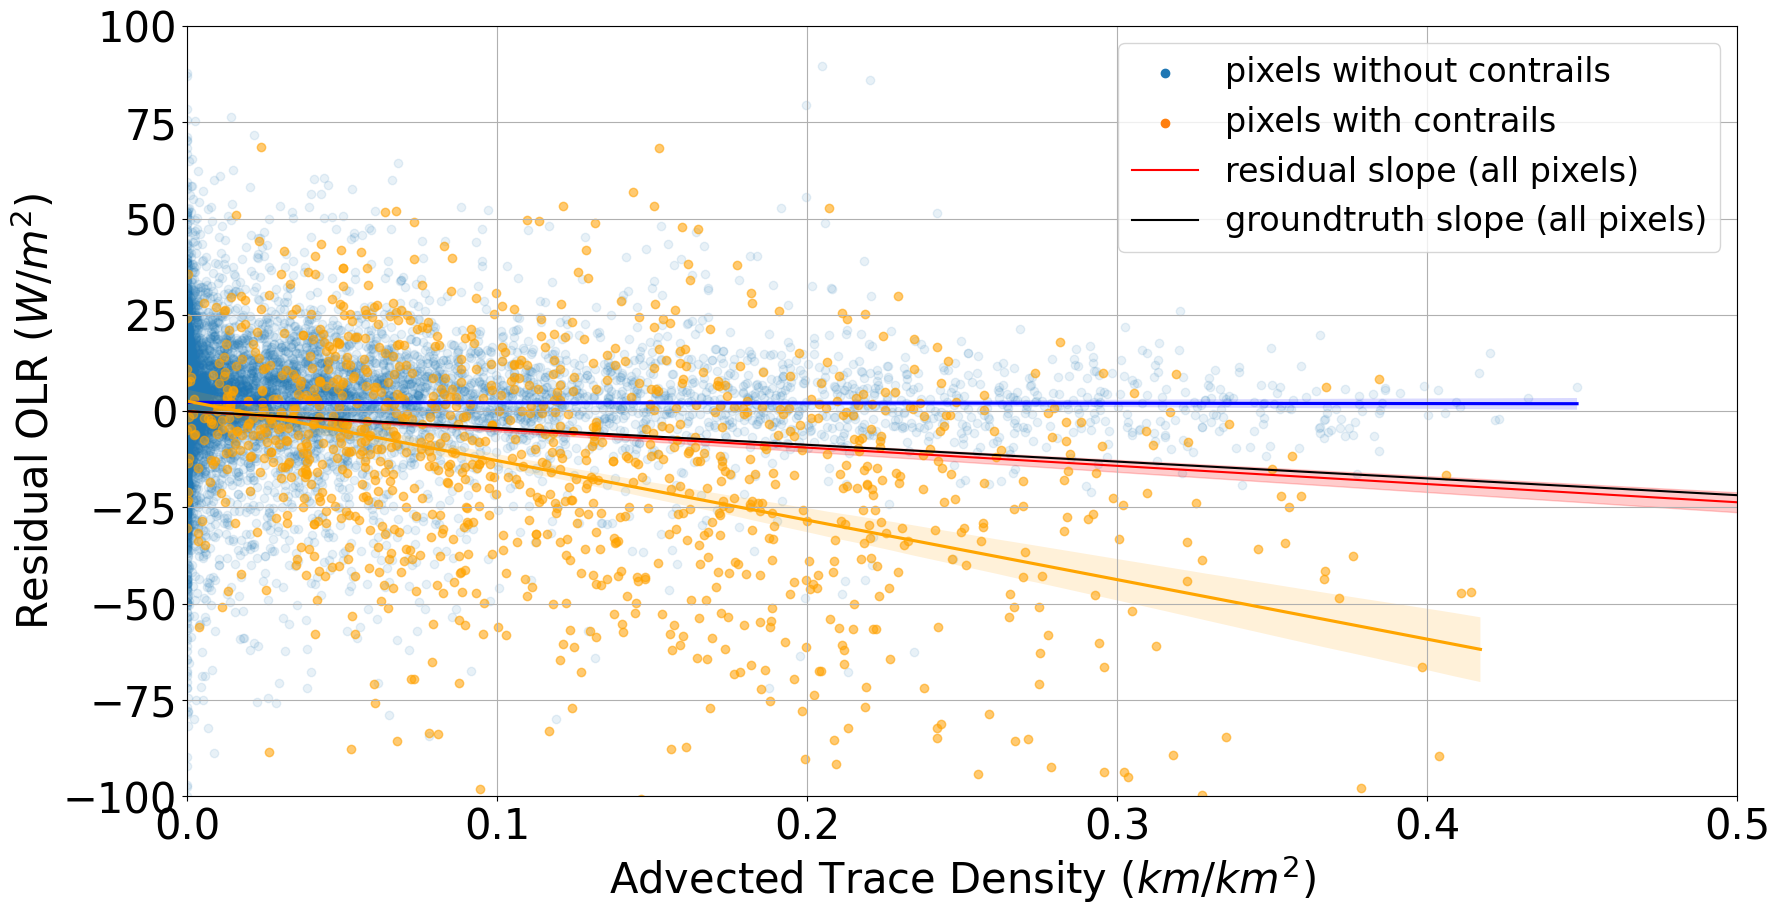

In [ ]:
def make_residual_slope_figure():
  df_2b = load_df(level='linear_b', shards_num=36)
  df_2b = format_df(df_2b)

  df = df_2b[df_2b.dayofyear == 254].copy().sample(10_000, replace=True)

  olr_model = fit_confounder_model(df)
  df['era_hat'] = olr_model.predict(df)
  df['olr_residual'] = df.coin_olr - df.era_hat

  plt.figure(figsize=(20,10))
  ndf = df[df.ground_truth_rf_lw >= 0]
  sns.regplot(ndf, x='fd_mean_lt_12', y='olr_residual', scatter_kws=dict(alpha=0.1), line_kws=dict(color='blue'), label='pixels without contrails')

  cdf = df[df.ground_truth_rf_lw < 0]
  sns.regplot(cdf, x='fd_mean_lt_12', y='olr_residual', scatter_kws=dict(alpha=0.1), line_kws=dict(color='orange'), label='pixels with contrails')

  slopes = []
  for _ in range(5):
    model = linear_model.LinearRegression(fit_intercept=True)
    sdf = df.sample(10_000, replace=True)
    params = model.fit(sdf.fd_mean_lt_12.values.reshape(-1, 1), sdf.olr_residual.values)
    slopes.append(params.coef_[0])
  slope = np.mean(slopes)
  stddev = np.std(slopes)

  x = np.linspace(0, 0.5)
  y = slope * x + 0
  y1 = (slope-2*stddev) * x + 0
  y2 = (slope+2*stddev) * x + 0
  plt.plot(x, y, color='red', label='residual slope (all pixels)')
  plt.fill_between(x, y1=y1, y2=y2, color='red', alpha=0.2)

  model = linear_model.LinearRegression(fit_intercept=True)
  params = model.fit(df.fd_mean_lt_12.values.reshape(-1, 1), df.ground_truth_rf_lw.values)
  slope = params.coef_[0]
  x = np.linspace(0, 0.5)
  y = slope * x + 0
  plt.plot(x, y, color='black', label='groundtruth slope (all pixels)')

  plt.scatter(cdf.fd_mean_lt_12, cdf.olr_residual, c='orange', alpha=0.5)
  plt.ylim(-100, 100)
  plt.xlim(0, 0.5)
  plt.grid()

  plt.xlabel('Advected Trace Density ($km/km^2$)')
  plt.ylabel('Residual OLR ($W/m^2$)')

  plt.legend(loc='upper right')

  legend = plt.gca().legend_
  for handle in legend.legend_handles:
    handle.set_alpha(1.0)

make_residual_slope_figure()

100%|██████████| 4/4 [00:49<00:00, 12.44s/it]


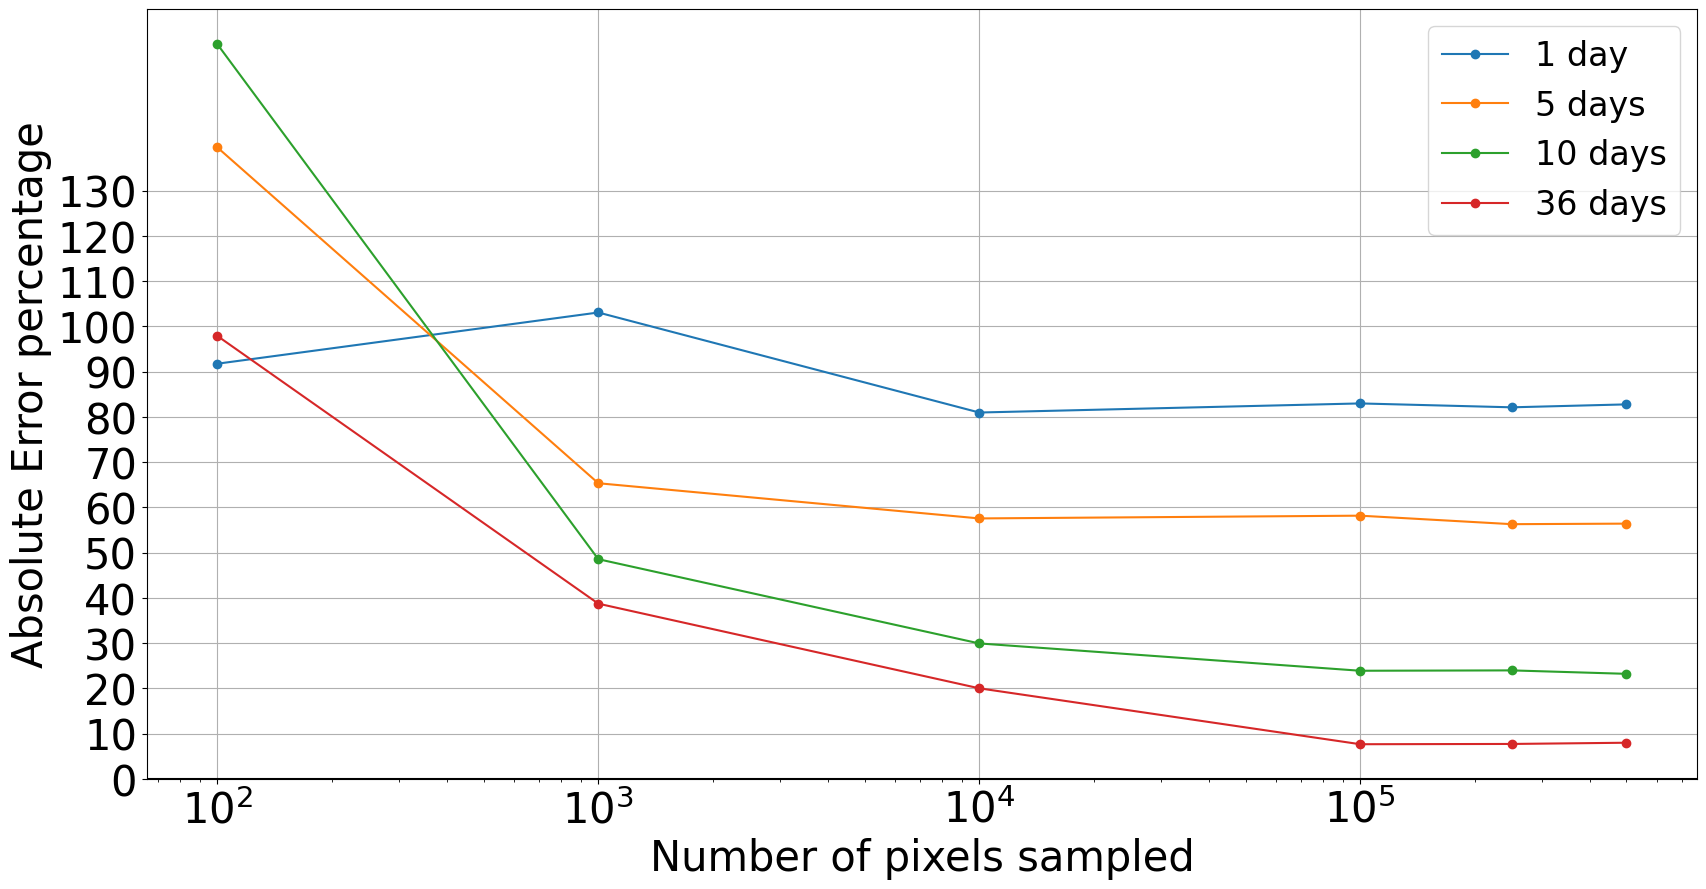

In [ ]:
def make_synthetic_num_days_figure():

  def load_linear_overlap_df():
    df_2a = load_df(level='linear_a')
    df_2a = format_df(df_2a)

    df_2b = load_df(level='linear_b')
    df_2b = format_df(df_2b)

    df_2d = load_df(level='linear_d')
    df_2d = format_df(df_2d)

    df_2e = load_df(level='linear_e')
    df_2e = format_df(df_2e)

    df_2 = pd.concat([df_2a, df_2b, df_2d, df_2e])
    del df_2a, df_2b, df_2d, df_2e
    return df_2

  def construct_numdaysneeded_dfs(olr_df, desired_effect_size, num_day_draws=3, daylist=None):
    days_in_df = [int(d) for d in np.unique(olr_df.dayofyear)]
    scaled_olr_df = copy.deepcopy(olr_df)

    # Remove synthetic contrails
    scaled_olr_df['coin_olr'] = olr_df.coin_olr - scaled_olr_df.ground_truth_rf_lw

    # Scale the groundtruth
    effect_size_scaler = desired_effect_size / COCIP_EFFECT_SIZE
    scaled_olr_df['ground_truth_rf_lw'] = scaled_olr_df['ground_truth_rf_lw'] * effect_size_scaler

    # Add back synthetic contrails
    scaled_olr_df['coin_olr'] = scaled_olr_df.coin_olr + scaled_olr_df.ground_truth_rf_lw

    # Calculate newly scaled groundtruth - of necessity this is for the sampled pixels,
    # but no matter which subset of days we draw below, they will be evaluated against
    # this value which is the averaged sample from all the days.
    olr_mean_fd = np.mean(scaled_olr_df.fd_mean_lt_12)
    mean_rf_lw = np.mean(scaled_olr_df.ground_truth_rf_lw)
    groundtruth_olr_gjkm = (mean_rf_lw / olr_mean_fd) * 3.6

    olr_df_by_doy = {}
    for doy, doy_df in scaled_olr_df.groupby('dayofyear'):
      olr_df_by_doy[doy] = doy_df

    # Generate an estimator dataframe from only a subset of days
    olr_estimator_dfs = collections.defaultdict(list)
    if daylist is None:
      daylist = list(range(1, len(days_in_df)+1))
    for num_days in tqdm(daylist):
      for day_draw in range(num_day_draws):
        doys = np.random.choice(days_in_df, num_days, replace=False)
        olr_dfs = []
        for doy in doys:
          olr_dfs.append(olr_df_by_doy[doy])
        olr_estimator_df = pd.concat(olr_dfs)
        olr_estimator_dfs[f'{num_days}_days'].append(olr_estimator_df)

    return olr_estimator_dfs, int(groundtruth_olr_gjkm)

  def add_residual(df):
    olr_model = fit_confounder_model(df)
    df['olr_hat'] = olr_model.predict(df)
    df['olr_residual'] = df.coin_olr - df.olr_hat
    return df

  def single_number_linefit_residual_already_exists(df, residual_col='olr_residual', fd_col_x='fd_mean_lt_12'):
    fitted_model = smf.ols(f'{residual_col} ~ {fd_col_x}', data=df).fit()
    slope = fitted_model.params[fd_col_x]
    gjkm_hat = round(slope * 3.6, 2)
    return gjkm_hat

  def calc_perpixel_error_percentages(olr_estimator_dfs, gt_olr_gjkm):
    olr_error_percentages_by_title = collections.defaultdict(list)

    for title, drawn_olr_estimator_dfs in tqdm(olr_estimator_dfs.items()):
      for olr_estimator_df in drawn_olr_estimator_dfs:
        for sample_size in [100, 1_000, 10_000, 100_000, 250_000, 500_000]:
          sdf = add_residual(olr_estimator_df.sample(sample_size, replace=True))
          gjkm_hat = single_number_linefit_residual_already_exists(sdf, residual_col='olr_residual')
          error_percent = round(((gjkm_hat - gt_olr_gjkm) / gt_olr_gjkm) * 100, 1)
          olr_error_percentages_by_title[title + '_' + str(sample_size)].append(abs(error_percent))
    return olr_error_percentages_by_title


  COCIP_EFFECT_SIZE = 11.5  # W/m2
  DEFAULT_SAMPLE_SIZE = 125_000
  np.random.seed(42)

  df_2 = load_linear_overlap_df()
  sample_size = int(DEFAULT_SAMPLE_SIZE * np.unique(df_2.dayofyear).shape[0])
  olr_df = df_2.sample(sample_size, replace=True)

  olr_estimator_dfs, gt_gjkm = construct_numdaysneeded_dfs(olr_df, desired_effect_size=COCIP_EFFECT_SIZE, num_day_draws=10, daylist=[1, 5, 10, 36])

  olr_error_percentages_by_title = calc_perpixel_error_percentages(olr_estimator_dfs, gt_gjkm)

  plt.figure(figsize=(20, 10))
  data_by_days = collections.defaultdict(list)
  for key, errors in olr_error_percentages_by_title.items():
    num_days, sample_size = key.split('_days_')
    num_days = int(num_days)
    sample_size = int(sample_size)
    for error in errors:
      data_by_days[num_days].append({'sample_size': sample_size, 'error': error})

  for num_days, data in data_by_days.items():
    df = pd.DataFrame(data)
    df = df.sort_values('sample_size')
    xs = []
    ymeans = []
    for _, sdf in df.groupby('sample_size'):
      xs.append(int(sdf.iloc[0].sample_size))
      ymeans.append(np.mean(sdf.error))

    if num_days == 1:
      label = f'1 day'
    else:
      label = f'{num_days} days'
    plt.plot(xs, ymeans, marker='o', label=label)

  plt.grid()
  plt.axhline(0, c='black')
  plt.ylabel('Absolute Error percentage')
  plt.xlabel('Number of pixels sampled')
  plt.xscale('log')
  plt.legend()
  plt.yticks(np.arange(0, 140, 10))

make_synthetic_num_days_figure()